In [28]:
import folium
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import squarify 
import pandas as pd
from matplotlib.sankey import Sankey
import seaborn as sns

In [21]:
Penn = os.path.join('data', 'PA-42-pennsylvania-counties.json')


P = folium.Map(
    location=[40.885405, -77.827679],
    zoom_start=7,
    tiles='cartodbpositron'
)

#folium.TopoJson(
#    open(Penn),
#    'objects.cb_2015_pennsylvania_county_20m',
#    name='Penntopojson'
#)

folium.Choropleth(
    open(Penn),
    topojson='objects.cb_2015_pennsylvania_county_20m',
    #name='Pennchoropleth'
    #data=state_data,
    #columns=['State', 'Unemployment'],
    #key_on='feature.id',
    fill_color='BuGn',
    fill_opacity=0.4
    #line_opacity=0.2
    #legend_name='Unemployment Rate (%)'
).add_to(P)
P

In [32]:
WestV = os.path.join('data', 'WV-54-west-virginia-counties.json')


WV = folium.Map(
    location=[38.678190, -80.716949],
    zoom_start=7,
    tiles='cartodbdark_matter'
)

#folium.TopoJson(
#    open(WestV),
#    'objects.cb_2015_west_virginia_county_20m',
#    name='WVjson'
#).add_to(WV)
#folium.LayerControl().add_to(P)

folium.Choropleth(
    open(WestV),
    topojson='objects.cb_2015_west_virginia_county_20m',
    #name='Pennchoropleth'
    #data=state_data,
    #columns=['State', 'Unemployment'],
    #key_on='feature.id',
    fill_color='#f29d9d',
    line_color='#f0dede',
    line_weight=2,
    fill_opacity=0.3,
    highlight=True
    #line_opacity=0.2
    #legend_name='Unemployment Rate (%)'
).add_to(WV)

WV

In [133]:
Kent = os.path.join('data', 'KY-21-kentucky-counties.json')


K = folium.Map(
    location=[37.494283, -85.445286],
    zoom_start=7,
    tiles='Stamen Watercolor'
)

folium.TopoJson(
    open(Kent),
    'objects.cb_2015_kentucky_county_20m',
    name='Kjson'
).add_to(K)
#folium.LayerControl().add_to(P)
K

In [142]:
Ohio = os.path.join('data', 'OH-39-ohio-counties.json')


O = folium.Map(
    location=[40.218927, -82.762618],
    zoom_start=7,
    tiles='OpenStreetMap'
)

folium.TopoJson(
    open(Ohio),
    'objects.cb_2015_ohio_county_20m',
    name='Ojson'
).add_to(O)
#folium.LayerControl().add_to(P)
O

In [143]:
Virg = os.path.join('data', 'VA-51-virginia-counties.json')


V = folium.Map(
    location=[37.334646, -79.208599],
    zoom_start=7,
    tiles='Stamen Terrain'
)

folium.TopoJson(
    open(Virg),
    'objects.cb_2015_virginia_county_20m',
    name='Vjson'
).add_to(V)
#folium.LayerControl().add_to(P)
V

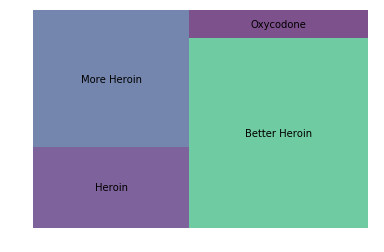

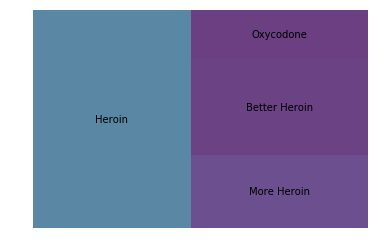

In [24]:
%matplotlib inline
 
# If you have 2 lists
squarify.plot(sizes=[13,22,35,5], label=["Heroin", "More Heroin", "Better Heroin", "Oxycodone"], alpha=.7 )
plt.axis('off')
plt.show()
 
# If you have a data frame?
df = pd.DataFrame({'nb_people':[8,3,4,2], 'group':["Heroin", "More Heroin", "Better Heroin", "Oxycodone"] })
squarify.plot(sizes=df['nb_people'], label=df['group'], alpha=.8 )
plt.axis('off')
plt.show() 

Text(0.5, 1.0, 'Sankey diagram with default settings')

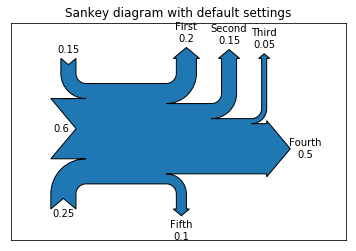

In [25]:
 # basic sankey chart
Sankey(flows=[0.25, 0.15, 0.60, -0.20, -0.15, -0.05, -0.50, -0.10], labels=['', '', '', 'First', 'Second', 'Third', 'Fourth', 'Fifth'], orientations=[-1, 1, 0, 1, 1, 1, 0,-1]).finish()
plt.title("Sankey diagram with default settings")

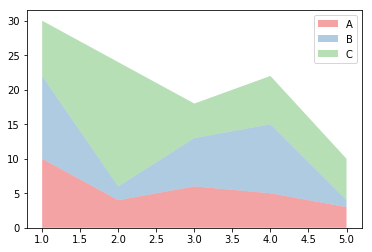

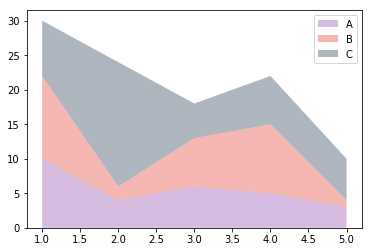

In [26]:
# Your x and y axis
x=range(1,6)
y=[ [10,4,6,5,3], [12,2,7,10,1], [8,18,5,7,6] ]
 
# use a known color palette (see..)
pal = sns.color_palette("Set1")
plt.stackplot(x,y, labels=['A','B','C'], colors=pal, alpha=0.4 )
plt.legend(loc='upper right')
plt.show()
 
# create your palette
pal = ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]
plt.stackplot(x,y, labels=['A','B','C'], colors=pal, alpha=0.4 )
plt.legend(loc='upper right')

/home/ryanibarra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  This is separate from the ipykernel package so we can avoid doing imports until


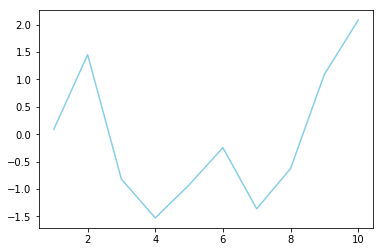

In [27]:
%matplotlib inline
df=pd.DataFrame({'x': range(1,11), 'y': np.random.randn(10) })
plt.plot( 'x', 'y', data=df, color='skyblue')
plt.show()